In [1]:
import os
import sys
import ast
import numpy as np
import pandas as pd
import cv2
import glob

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from skimage.measure import label, regionprops

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingLR

import albumentations as a_transform
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt
from utils import AverageMeter

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

WORKDIR = os.path.expanduser("~/project/data/ranzcr-clip-catheter-line-classification")
# WORKDIR = "../data/ranczr"

cuda:0


In [2]:
train_csv = pd.read_csv(os.path.join(WORKDIR, "train.csv"))
train_annot = pd.read_csv(os.path.join(WORKDIR, "train_annotations.csv"))
weird_uid = '1.2.826.0.1.3680043.8.498.93345761486297843389996628528592497280'
train_csv.loc[train_csv.StudyInstanceUID==weird_uid, 'ETT - Abnormal'] = 0
train_csv.loc[train_csv.StudyInstanceUID==weird_uid, 'CVC - Abnormal'] = 1
train_annot.loc[4344, 'label'] = 'CVC - Abnormal'
# tracheal_point = pd.read_csv(os.path.join(WORKDIR, "tracheal_bifurcation.csv"))

In [3]:
class CFG:
    debug=False
    print_freq=100
    num_workers=4
    model_name='resnext50_32x4d'
    size=256
    scheduler='CosineAnnealingLR'
    epochs=5
    T_max=6 
    lr=0.001
    min_lr=0.000001
    batch_size=16
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=1234
    target_size=11
    target_cols=['ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal',
                 'NGT - Abnormal', 'NGT - Borderline', 'NGT - Incompletely Imaged', 
                 'NGT - Normal', 
                 'CVC - Abnormal', 'CVC - Borderline', 'CVC - Normal',
                 'Swan Ganz Catheter Present']
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    train=True
    
# if CFG.debug:
#     CFG.epochs = 1
#     train = train.sample(n=100, random_state=CFG.seed).reset_index(drop=True)

# CV split creation

In [4]:
folds = train_csv.copy()
Fold = GroupKFold(n_splits=CFG.n_fold)
groups = folds['PatientID'].values
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_cols], groups)):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
display(folds.groupby('fold').size())

fold
0    7521
1    7521
2    7521
3    7520
dtype: int64

# Dataset, DataLoader and Transform

In [148]:
normalize = a_transform.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225], p=1.0, max_pixel_value=255.0)

train_transform = a_transform.Compose([a_transform.RandomResizedCrop(256, 256, scale=(0.85,1.), p=1.0),
                                       a_transform.HorizontalFlip(p=0.5),
                                       normalize,
                                       ToTensorV2()
                                       ], p=1.0)

valid_transform = a_transform.Compose([a_transform.Resize(512, 512), normalize, ToTensorV2()], p=1.0)
# valid_transform = a_transform.Compose([normalize, ToTensorV2()], p=1.0)


In [ ]:
from dataset import TrainDataset, SegDataset, AnnotDataset

# Select fold - loop curfold
curfold = 0
trn_idx = folds[folds['fold'] != curfold].index
val_idx = folds[folds['fold'] == curfold].index

train_folds = folds.loc[trn_idx].reset_index(drop=True)
valid_folds = folds.loc[val_idx].reset_index(drop=True)

train_folds = train_folds[train_folds['StudyInstanceUID'].isin(train_annot['StudyInstanceUID'].unique())].reset_index(drop=True)
valid_folds = valid_folds[valid_folds['StudyInstanceUID'].isin(train_annot['StudyInstanceUID'].unique())].reset_index(drop=True)

valid_labels = valid_folds[CFG.target_cols].values

# train_uid = [x for x in train_folds["StudyInstanceUID"].values]
# valid_uid = [x for x in valid_folds["StudyInstanceUID"].values]
# Initialize train and valid dataset
train_dataset = AnnotDataset(WORKDIR, train_folds, train_annot,
                             flip_transform=train_transform, 
                             target_cols=CFG.target_cols)
valid_dataset = AnnotDataset(WORKDIR, valid_folds, train_annot,
                             flip_transform=valid_transform, 
                             target_cols=CFG.target_cols)

# Initialize dataloader for fast parsing
train_loader = DataLoader(train_dataset, 
                          batch_size=CFG.batch_size, 
                          shuffle=True, 
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, 
                          batch_size=CFG.batch_size, 
                          shuffle=False, 
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)



# Idea

## 1. Lung Segmentation map

Train Pix2Pix for lung segmentation. Dynamically crop the bbox and focus only on the cropped image.

## 2. Relative Position

Model the relative position of the catheters to lungs. Think heatmapping.



In [ ]:
# Generator
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet


body = create_body(resnet18, pretrained=True, n_in=3, cut=-2)
netG = DynamicUnet(body, 1, (256, 256)).to(device)

In [ ]:
# Discriminator

class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2) 
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or
                                                                                             # activation for the last layer of the model
        self.model = nn.Sequential(*model)                                                   
        
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

# input channel is 4 because we its conditional GAN
netD = PatchDiscriminator(4).to(device)

In [ ]:
class GANLoss(nn.Module):
    def __init__(self, use_lsgan=True, target_real_label=1.0, target_fake_label=0.0):
        super(GANLoss, self).__init__()
        self.register_buffer('real_label', torch.tensor(target_real_label))
        self.register_buffer('fake_label', torch.tensor(target_fake_label))
        if use_lsgan:
            self.loss = nn.MSELoss()
        else:
            # self.loss = nn.BCELoss()
            self.loss = nn.BCEWithLogitsLoss()

    def get_target_tensor(self, in_vec, target_is_real):
        if target_is_real:
            target_tensor = self.real_label
        else:
            target_tensor = self.fake_label
        return target_tensor.expand_as(in_vec)

    def __call__(self, in_vec, target_is_real):
        target_tensor = self.get_target_tensor(in_vec, target_is_real)
        return self.loss(in_vec, target_tensor)


# Train Loop for the Unet-GAN

In [ ]:
optG = torch.optim.Adam(netG.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
optD = torch.optim.Adam(netD.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
# CFG.T_max = int(CFG.epochs * len(train_loader))

schedulerG = torch.optim.lr_scheduler.CosineAnnealingLR(optG, T_max=CFG.T_max, eta_min=CFG.min_lr)
schedulerD = torch.optim.lr_scheduler.CosineAnnealingLR(optD, T_max=CFG.T_max, eta_min=CFG.min_lr)

criterionGAN = GANLoss(False).to(device)
criterionL1 = nn.L1Loss()
criterion_recon = nn.BCEWithLogitsLoss()

In [ ]:
for epc in range(CFG.epochs):

    for img_mb, mask_mb, _ in train_loader:
        img_mb = img_mb.to(device)
        # mask_mb = mask_mb.to(device)

        #### Train netD ####
        optD.zero_grad()

        # train with fake
        fake_mask = netG(img_mb)
        fake_ab = torch.cat((img_mb, fake_mask), dim=1)
        fake_D = netD(fake_ab.detach())
        lossD_fake = criterionGAN(fake_D, False)

        # train with real
        real_ab = torch.cat((img_mb, mask_mb[0].to(device)), dim=1)
        real_D = netD(real_ab)
        lossD_real = criterionGAN(real_D, True)

        lossD = (lossD_fake + lossD_real) * 0.5
        lossD.backward()
        optD.step()
        
        #### Train netG ####
        optG.zero_grad()

        # First, G(A) should fake the discriminator
        fake_ab = torch.cat((img_mb, fake_mask), dim=1)
        fake_D = netD(fake_ab)
        lossG_gan = criterionGAN(fake_D, True)

        # Second, G(A) = B
        lossG_l1 = criterionL1(fake_mask, mask_mb[0].to(device)) * 0.1
        lossG = lossG_gan + lossG_l1
        
        lossG.backward()
        optG.step()
    schedulerG.step()
    schedulerD.step()
    avg_psnr = 0
    # TODO: fix the reporting metric
    with torch.no_grad():
        for batch in valid_loader:
            img_mb, mask_mb = batch[0].to(device), batch[1][0].to(device)

            prediction = netG(img_mb)
            mse = criterion_recon(prediction, mask_mb)
            # psnr = 10 * log10(1 / mse.item())
            avg_psnr += mse
        print(f"===> Epoch [{epc+1}] Avg. PSNR: {avg_psnr / len(valid_loader):.4f} dB")


# Train Smaller U-net

In [3]:
from unet import UNet

# net = UNet(n_channels=3, n_classes=1, bilinear=True).to(device)
# optimizer = torch.optim.Adam(net.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr)

# criterion_recon = nn.BCEWithLogitsLoss()

In [ ]:
best_loss = np.inf
for epc in range(CFG.epochs):
    losses = AverageMeter()
    # scores = AverageMeter()
    for step, (img_mb, mask_mb, _) in enumerate(train_loader):
        img_mb = img_mb.to(device)

        # Model prediction
        mask_pred = net(img_mb)
        recon_loss = criterion_recon(mask_pred, mask_mb[0].to(device))
        batch_size = img_mb.size(0)
        # Record Loss
        losses.update(recon_loss.item(), batch_size)
        optimizer.zero_grad()
        recon_loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(net.parameters(), 1000)
        optimizer.step()

        if step % 100 == 0 or step == (len(train_loader)-1):
            print_str = f'Epoch: [{epc+1}][{step}/{len(train_loader)}] '\
            f'Loss: {losses.val:.4f}({losses.avg:.4f}) '\
            f'Grad: {grad_norm:.4f}'
            print(print_str)

    scheduler.step()
    avg_valid = AverageMeter()
    # TODO: fix the reporting metric
    with torch.no_grad():
        for batch in valid_loader:
            img_mb, mask_mb = batch[0].to(device), batch[1][0].to(device)
            prediction = net(img_mb)
            mse = criterion_recon(prediction, mask_mb)
            avg_valid.update(mse.item(), img_mb.size(0))
        print(f"===> Epoch [{epc+1}] {avg_valid.val:.4f}({avg_valid.avg:.4f})")
        if avg_valid.avg < best_loss:
            best_loss = avg_valid.avg
            print(f'Epoch {epc+1} - Save Best Loss: {best_loss:.4f} Model')
            torch.save({'model': net.state_dict()},
                        f'seg-fcn8_best.pth')


## Load Trained Unet Segmentation model

In [138]:
tube_net = UNet(n_channels=3, n_classes=1, bilinear=True).to(device)
checkpoint = torch.load("tube-seg-unet_best.pth")
tube_net.load_state_dict(checkpoint["model"])
tube_net.eval()

lung_net = UNet(n_channels=3, n_classes=1, bilinear=True).to(device)
checkpoint = torch.load("lung-seg-unet_best.pth")
lung_net.load_state_dict(checkpoint["model"])
lung_net.eval()


UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

# Visual Checking Space

In [10]:
class ValidDataset(Dataset):
    def __init__(self, root, df, transform=None, target_cols=None):
        self.root = root
        self.df = df
        self.img_idx = df["StudyInstanceUID"].values
        self.labels = torch.from_numpy(df[target_cols].values).float()
        self.transform = transform
        self.train_path = os.path.join(self.root, "train")
        # self.clahe = cv2.createCLAHE(clipLimit=30.0, tileGridSize=(8, 8))

    def __len__(self):
        return len(self.img_idx)

    def __getitem__(self, idx):
        file_name = self.img_idx[idx]
        file_path = f"{self.train_path}/{file_name}.jpg"
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        image_size = image.shape
        # image = self.clahe.apply(image)
        # image = reshape_img(image)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]

        label = self.labels[idx]
        return image, file_name, image_size


In [47]:
new_mask = pred_tube_mask*255
new_mask = new_mask.astype(np.uint8)
# new_mask = np.expand_dims(new_mask,axis=2)
# new_mask = new_mask.repeat(3,2)
# edges = cv2.Canny(new_mask,50,150,apertureSize = 3)
new_image = cv2.HoughLinesP(new_mask, 1, np.pi / 180, 50, None, 50, 10)

In [89]:
ctr_cord

[[2018, 1036],
 [2056, 1142],
 [2085, 1205],
 [2110, 1284],
 [2116, 1335],
 [2106, 1398],
 [2070, 1436],
 [2054, 1483],
 [2041, 1577],
 [2031, 1661]]

['ETT - Normal' 'CVC - Normal' 'CVC - Borderline']


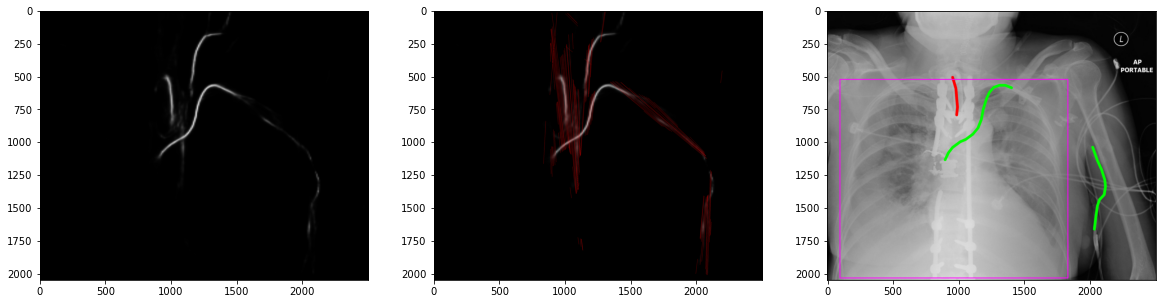

In [88]:
# Visual check

uid = train_annot.StudyInstanceUID.values[950]
uid = weird_uid[0]
an_img = cv2.imread(os.path.join(WORKDIR, f"train/{uid}.jpg"))
# img = valid_transform(image=an_img)["image"]
# img = cv2.imread(os.path.join(valid_dataset.img_path, f'{valid_dataset.file_names[idx]}.jpg'))
# pred_lung_mask = torch.sigmoid(lung_net(img.unsqueeze(0).to(device))).detach().cpu().squeeze(0).squeeze(0).numpy()
# pred_tube_mask = torch.sigmoid(tube_net(img.unsqueeze(0).to(device))).detach().cpu().squeeze(0).squeeze(0).numpy()
pred_tube_mask = cv2.imread(os.path.join(WORKDIR, f"train_tube_masks/{uid}.jpg"),-1)
pred_lung_mask = cv2.imread(os.path.join(WORKDIR, f"train_lung_masks/{uid}.jpg"),-1)

ctr_lines = train_annot[train_annot.StudyInstanceUID == uid].data.values
ctr_labels = train_annot[train_annot.StudyInstanceUID == uid].label.values
print(ctr_labels)
ctr_color = {"ETT": (255,0,0), "CVC": (0,255,0), "NGT": (0,0,255)}
for each_ctr, each_label in zip(ctr_lines,ctr_labels):
    ctr_cord = ast.literal_eval(each_ctr)
    cv2.polylines(an_img, np.array([[np.array(x) for x in ctr_cord]]), isClosed=False, color=ctr_color[each_label[:3]], thickness=20)

mask = pred_tube_mask < 100
pred_tube_mask[mask] = 0
tube_mask_line = pred_tube_mask
tube_mask_line = tube_mask_line.astype(np.uint8)
lines = cv2.HoughLinesP(tube_mask_line, rho=5, theta=np.pi/360, threshold=200, minLineLength=50, maxLineGap=50)
tube_mask_line = cv2.cvtColor(tube_mask_line, cv2.COLOR_GRAY2RGB)
for idx in range(lines.shape[0]):
    if idx >= 100:
        break
    x1 = lines[idx][0][0]
    y1 = lines[idx][0][1]
    x2 = lines[idx][0][2]
    y2 = lines[idx][0][3]
    cv2.line(tube_mask_line,(x1,y1),(x2,y2),(255,0,0),1)
    
props = regionprops(pred_lung_mask)
nms_box = cnms(props)
cv2.rectangle(an_img, (nms_box[1], nms_box[0]), (nms_box[3], nms_box[2]), (255, 0, 255), 5)
plt.figure(figsize=(20,15))
plt.subplot(1,3,1)
plt.imshow(pred_tube_mask,'gray')
plt.subplot(1,3,2)
# write function here
plt.imshow(tube_mask_line)
plt.subplot(1,3,3)
plt.imshow(an_img)

plt.show()

['CVC - Borderline' 'CVC - Normal']


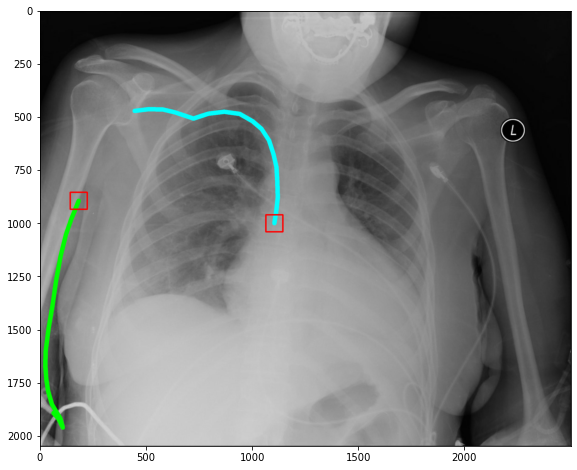

In [22]:
uid = '1.2.826.0.1.3680043.8.498.33405757377859280217196887683923874136'
img = cv2.imread(os.path.join(WORKDIR, f"train/{uid}.jpg"))
ctr_lines = train_annot[train_annot.StudyInstanceUID == uid].data.values
ctr_labels = train_annot[train_annot.StudyInstanceUID == uid].label.values
print(ctr_labels)
ctr_color = {"ETT": (255,0,0), "CVC - Borderline": (0,255,0), "CVC - Normal": (0,255,255), "NGT": (0,0,255)}
center_pix = np.array((img.shape[1]//2, img.shape[0]//2))
for each_ctr, each_label in zip(ctr_lines,ctr_labels):
    ctr_cord = ast.literal_eval(each_ctr)
    cv2.polylines(img, np.array([[np.array(x) for x in ctr_cord]]), isClosed=False, color=ctr_color[each_label], thickness=20)
    tip_cord = end_tip([ctr_cord[0], ctr_cord[-1]], center_pix)
    x_min = tip_cord[0]-40
    x_max = tip_cord[0]+40
    y_min = tip_cord[1]-40
    y_max = tip_cord[1]+40
    cv2.rectangle(img, (x_min, y_min),(x_max, y_max),(255,0,0),5)

plt.figure(figsize=(12,8))
plt.imshow(img)
plt.show()

In [ ]:
train_annot[train_annot.StudyInstanceUID == uid]

In [ ]:
# uid = train_annot.StudyInstanceUID.values[9485]
img = cv2.imread(os.path.join(WORKDIR, f"train/{uid}.jpg"), -1)
# img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
mask_img = np.zeros_like(img)
# blank_img = np.zeros_like(img)
ctr_lines = train_annot[train_annot.StudyInstanceUID == uid].data.values
ctr_labels = train_annot[train_annot.StudyInstanceUID == uid].label.values
print(ctr_labels)
ctr_color = {"ETT": (255,0,0), "CVC": (255,0,0), "NGT": (255,0,0)}
for each_ctr, each_label in zip(ctr_lines,ctr_labels):
    ctr_cord = ast.literal_eval(each_ctr)
    mask_img = cv2.polylines(mask_img, np.array([[np.array(x) for x in ctr_cord]]), isClosed=False, color=ctr_color[each_label[:3]], thickness=20)
# ctr_1 = ast.literal_eval(train_annot[train_annot.StudyInstanceUID == uid].loc[17523,"data"])
# ctr_2 = ast.literal_eval(train_annot[train_annot.StudyInstanceUID == uid].loc[17521,"data"])
# img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img[:,:,2] = mask_img
# blank_img = cv2.polylines(blank_img, np.array([[np.array(x) for x in ctr_1]]), isClosed=False, color=(255,), thickness=20)
# blank_img = cv2.polylines(blank_img, np.array([[np.array(x) for x in ctr_2]]), isClosed=False, color=(255,), thickness=20)
# img = cv2.polylines(img, np.array([[np.array(x) for x in ctr_2]]), isClosed=False, color=(0,255), thickness=20)
# img = cv2.drawContours(img, np.array([[np.array(x) for x in ctr_2]]), 0, (255), 5)
plt.figure(figsize=(10,10))
plt.imshow(img,"gray")
plt.show()

In [ ]:
uid = train_csv.StudyInstanceUID.values[1]
img = cv2.imread(os.path.join(WORKDIR,f"cropped_train/{uid}.jpg"),cv2.IMREAD_GRAYSCALE)
clahe = cv2.createCLAHE(clipLimit=30.0, tileGridSize=(8,8))
cl_img = clahe.apply(img)

ht, wd = cl_img.shape
ww = max(ht+2,wd+2)
hh = ww
constant = np.zeros((hh,ww), dtype=np.uint8)
xx = (ww-wd)//2
yy = (hh-ht)//2
constant[yy:yy+ht, xx:xx+wd] = cl_img

target_area = 1024*1024
ratio = float(constant.shape[1])/float(constant.shape[0])
new_h = int(np.sqrt(target_area / ratio) + 0.5)
new_w = int((new_h * ratio) + 0.5)

res_img = cv2.resize(constant, (new_w,new_h))

plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(img,'gray')
plt.subplot(1,3,2)
plt.imshow(cl_img,'gray')
plt.subplot(1,3,3)
plt.imshow(res_img,'gray')
plt.show()

# Preprocessing Image

In [ ]:
# Create Tube Segmentation Mask
for idx, arow in train_annot.iterrows():
    if (idx+1) % 500 == 0 or idx == train_annot.shape[0]-1:
        print(f"Processing {idx+1}")
    uid = arow[0]
    tube_type = arow[1][:3]
    annot = ast.literal_eval(arow[-1])
    img = cv2.imread(os.path.join(WORKDIR,f"train/{uid}.jpg"),cv2.IMREAD_GRAYSCALE)
    mask_img = np.zeros_like(img)
    mask_img = cv2.polylines(mask_img, np.array([[np.array(x) for x in annot]]), isClosed=False, color=(255,), thickness=5)

    ii = 0
    file_name = os.path.join(WORKDIR,f"cat_masks/{uid}-{tube_type}-{ii}.jpg")
    while os.path.exists(file_name):
        ii += 1
        file_name = os.path.join(WORKDIR,f"cat_masks/{uid}-{tube_type}-{ii}.jpg")

    cv2.imwrite(file_name, mask_img)
    # if idx == 10:
    #     break

In [ ]:
# Create CLAHE'd image
clahe = cv2.createCLAHE(clipLimit=30.0, tileGridSize=(8,8))

for idx, arow in train_csv.iterrows():
    if idx == train_annot.shape[0]-1:
        print(f"Processing {idx+1}")
    uid = arow[0]
    img = cv2.imread(os.path.join(WORKDIR,f"train/{uid}.jpg"),cv2.IMREAD_GRAYSCALE)
    cl_img = clahe.apply(img)
    
    # zero pad
    ht, wd = cl_img.shape
    ww = max(ht+2,wd+2)
    hh = ww
    constant = np.zeros((hh,ww), dtype=np.uint8)
    xx = (ww-wd)//2
    yy = (hh-ht)//2
    constant[yy:yy+ht, xx:xx+wd] = cl_img

    target_area = 1024*1024
    ratio = float(constant.shape[1])/float(constant.shape[0])
    new_h = int(np.sqrt(target_area / ratio) + 0.5)
    new_w = int((new_h * ratio) + 0.5)

    res_img = cv2.resize(constant, (new_w,new_h))
    file_name = os.path.join(WORKDIR,f"preprocessed_train/{uid}.jpg")
    cv2.imwrite(file_name, res_img)


In [11]:
def cnms(proposal_bboxs):
    """
    Select largest bounding box
    """
    abox = proposal_bboxs[0].bbox
    min_row = abox[0]
    min_col = abox[1]
    max_row = abox[2]
    max_col = abox[3]
    # (min_row, min_col, max_row, max_col)
    for prop in proposal_bboxs:
        abox = prop.bbox
#         if abox[0] < min_row or abox[1] < min_col or abox[2] > max_row or abox[3] > max_col:
#             min_row = abox[0]
#             min_col = abox[1]
#             max_row = abox[2]
#             max_col = abox[3]
        if abox[0] < min_row:
            min_row = abox[0]
        if abox[1] < min_col:
            min_col = abox[1]
        if abox[2] > max_row:
            max_row = abox[2]
        if abox[3] > max_col:
            max_col = abox[3]
    return (min_row, min_col, max_row, max_col)

In [12]:
def find_out(tip_cord, bbox):
    """
    Find tip not in bbox
    """
    if tip_cord[0] > bbox[-1] or tip_cord[0] < bbox[1]:
        return 1
    return 0

In [15]:
def end_tip(tip_cords, cp):
    dist1 = np.linalg.norm(tip_cords[0]-cp)
    dist2 = np.linalg.norm(tip_cords[1]-cp)
    if dist1 < dist2:
        return tip_cords[0]
    else:
        return tip_cords[1]


def create_tip_bbox():
    pass

In [41]:
border_line_mask = train_annot.label == "CVC - Borderline"
weird_uid = []
for idx in range(np.sum(border_line_mask)):
    uid = train_annot[border_line_mask].StudyInstanceUID.values[idx]
    annot = ast.literal_eval(train_annot[border_line_mask].data.values[idx])
    lung_mask = cv2.imread(os.path.join(WORKDIR,f"train_lung_masks/{uid}.jpg"), -1)
    props = regionprops(lung_mask)
    nms_box = cnms(props)
    if find_out(annot[0], nms_box) and find_out(annot[-1], nms_box):
        print(f"found: {uid}")
        weird_uid.append(uid)
    

found: 1.2.826.0.1.3680043.8.498.63436128186147039711788993995764736874
found: 1.2.826.0.1.3680043.8.498.86139864725826457455784758464211676938
found: 1.2.826.0.1.3680043.8.498.33405757377859280217196887683923874136
found: 1.2.826.0.1.3680043.8.498.10011645222415989937696288265656661857
found: 1.2.826.0.1.3680043.8.498.72841440903520012109808284159201193252
found: 1.2.826.0.1.3680043.8.498.46154211943204711926515188750982063801
found: 1.2.826.0.1.3680043.8.498.73537792158439334813961842257363689219
found: 1.2.826.0.1.3680043.8.498.99726775868722535075639207053678923407
found: 1.2.826.0.1.3680043.8.498.11693509889426445054876979814173446281
found: 1.2.826.0.1.3680043.8.498.45771438389981173574539940217335146621
found: 1.2.826.0.1.3680043.8.498.92295527360008316831136651082453075817
found: 1.2.826.0.1.3680043.8.498.11881912214252557846819720135643941063
found: 1.2.826.0.1.3680043.8.498.10017151185038598671064029373595425922
found: 1.2.826.0.1.3680043.8.498.9638960787103280078280230776264

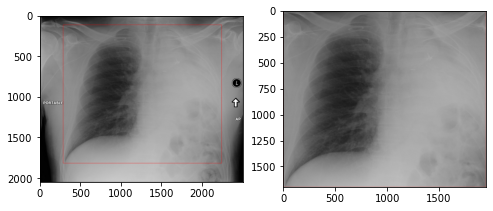

In [5]:
from skimage.measure import label, regionprops

mask_paths = glob.glob(os.path.join(WORKDIR,"train_lung_masks/*.jpg"))
uid = mask_paths[198].split("/")[-1][:-4]
img = cv2.imread(os.path.join(WORKDIR,f"train/{uid}.jpg"))
img_mask = cv2.imread(os.path.join(WORKDIR,f"train_lung_masks/{uid}.jpg"), -1)
props = regionprops(img_mask)
# write function here
nms_box = cnms(props)
# for prop in props:
    # print(prop.bbox)
cv2.rectangle(img, (nms_box[1], nms_box[0]), (nms_box[3], nms_box[2]), (255, 0, 0), 2)
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(img,'gray')
plt.subplot(1,2,2)
plt.imshow(img[nms_box[0]:nms_box[2], nms_box[1]:nms_box[3]], 'gray')
plt.show()
new_img = img[nms_box[0]:nms_box[2], nms_box[1]:nms_box[3]]
# cv2.imwrite(os.path.join(WORKDIR,f"cropped_train/{uid}.jpg"),new_img)

In [ ]:
# DO NOT RUN/DELETE

# for apath in mask_paths:
#     uid = apath.split("/")[-1][:-4]
#     img = cv2.imread(os.path.join(WORKDIR,f"train/{uid}.jpg"))
#     img_mask = cv2.imread(os.path.join(WORKDIR,f"train_lung_masks/{uid}.jpg"), -1)
#     props = regionprops(img_mask)
#     nms_box = cnms(props)
#     new_img = img[nms_box[0]:nms_box[2], nms_box[1]:nms_box[3]]
#     cv2.imwrite(os.path.join(WORKDIR,f"cropped_train/{uid}.jpg"),new_img)

In [ ]:
uid='1.2.826.0.1.3680043.8.498.10000428974990117276582711948006105617'
img = cv2.imread(os.path.join(WORKDIR,f"train_lung_masks/{uid}.jpg"))
plt.imshow(img,'gray')
# img.shape